### Import data

In [1]:
include("importData.jl")
include("DDEmodel.jl")
include("Hill.jl")
include("plot.jl")
# hillParams should be something like [alpha_min, alpha_max, alpha_EC50, alpha_b, beta_min, beta_max, beta_EC50, beta_b...]
param_lap_dde = CSV.read(".//figures//Lapatinib//params_lap_DDE.csv")
concentrations = permutedims(Vector(param_lap_dde[8,2:end]));
print(concentrations)

# import G1 and G2 data
pop, g2, g1, g1_0, g2_0 = get_data("..//data//lap.csv", "..//data//lap_pop.csv");



Any[0.0 5.0 10.0 25.0 50.0 100.0 250.0 500.0]

In [2]:
low = 0.0001*zeros(28)
high_temp = [3.0, 3.0, 95.0, 3.0]
high = repeat(high_temp, 7)
guess = [1.1, 0.1, 50.0, 0.01, 0.1, 1.1, 50.0, 0.01, 1.1, 0.1, 50.0, 0.01, 1.1, 0.1, 50.0, 0.01, 1.1, 0.1, 50.0, 0.01, 1.3, 0.3, 50.0, 0.01, 1.3, 0.3, 50.0, 0.01]

optimizer_result = optimize_hill(concentrations, guess, low, high)


Results of Optimization Algorithm
 * Algorithm: LevenbergMarquardt
 * Minimizer: [1.358536273032791,0.42545179021067797,33.71299322229372,7.367669883084092e-5,0.1682332821951903,1.303913049198419,66.01780117166906,0.013050657734631967,1.2672535106683251,0.2720919554386144,26.504007258647828,0.0045462558894574,1.1880870967776536,0.16220521695297066,40.44104933405613,0.007755984237896869,3.0,3.0,50.14888553671771,0.0,1.2692854756944065,0.28346415047384416,50.4776588768818,0.01624919986351511,1.2439720015491567,0.29048581873667256,50.8439090525333,0.018343461454641965]
 * Sum of squares at Minimum: 633261.455789
 * Iterations: 22
 * Convergence: true
 * |x - x'| < 1.0e-08: true
 * |f(x) - f(x')| / |f(x)| < 1.0e-08: false
 * |g(x)| < 1.0e-08: false
 * Function Calls: 23
 * Gradient Calls: 12
 * Multiplication Calls: 66


### Plot Hill curve for alpha (first parameter)

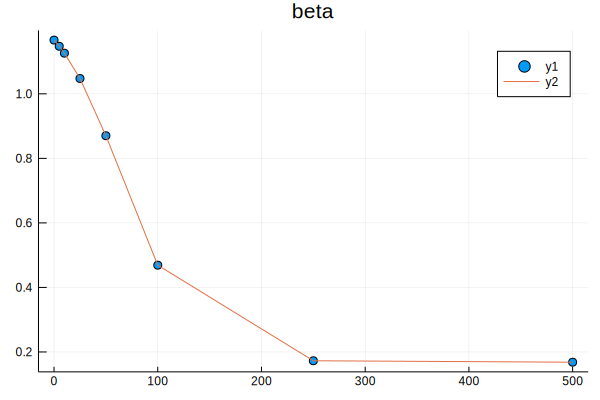

In [10]:
using Plots;
params = optimizer_result.minimizer
alpha = zeros(8)
for i in 1:8
    alpha[i] = hill(params[5:8], concentrations[i])
end


c = permutedims(Array(concentrations))
scatter(c, alpha, title = "beta")
plot!(c, alpha)

### Plot the data with the new set of parameters for DDE

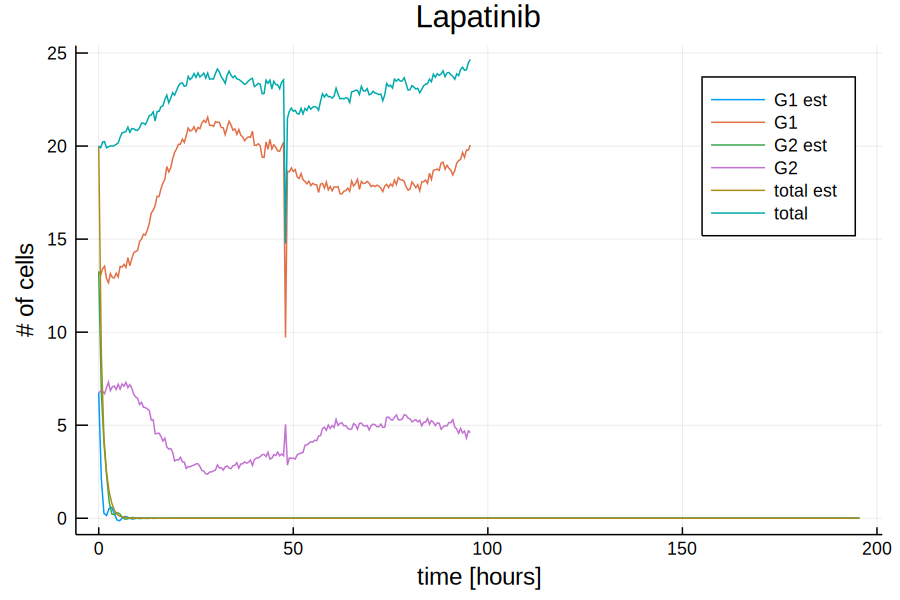

In [4]:

# for instance we want to plot the data and estimated for trial 7
alpha_7 = hill(params[1:4], concentrations[7])
beta_7 = hill(params[5:8], concentrations[7])
tau1_7 = hill(params[9:12], concentrations[7])
tau2_7 = hill(params[13:16], concentrations[7])
history_7 = hill(params[17:20], concentrations[7])
gamma1_7 = hill(params[21:24], concentrations[7])
gamma2_7 = hill(params[25:28], concentrations[7])

control = [alpha_7, beta_7, tau1_7, tau2_7, history_7, gamma1_7, gamma2_7]
plotIt(control, g1, g2, g1_0, g2_0, pop, 7, "Lapatinib")